In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from transformers import pipeline

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Cálculo de rendimiento de los jugadores a partir de sus estadísticas

In [2]:
df = pd.read_csv('raw/player_stats/Miguel_Gutiérrez_data.csv')
df.head()

,Fecha,Día,Competencia,Ronda,Sedes,Resultado,Equipo,Adversario,Arranque,Posición,...,Faltas cometidas,Faltas recibidas,Posición adelantada,Penales ejecutados,Penales concedidos,Goles en contra,Recuperación de pelotas,Aéreos Ganados,Aéreos Perdidos,% of Aerials Won
0,2023-08-12,Sáb,La Liga,Semana 1 de partido,Visitante,E 1–1,Girona,Real Sociedad,Sí,LB,...,1,0,0,0.0,0.0,0,3.0,2.0,0.0,100.0
1,2023-08-20,Dom,La Liga,Semana 2 de partido,Local,V 3–0,Girona,Getafe,Sí,LB,...,0,0,0,0.0,0.0,0,5.0,2.0,0.0,100.0
2,2023-08-26,Sáb,La Liga,Semana 3 de partido,Visitante,V 2–1,Girona,Sevilla,Sí,LB,...,0,1,0,0.0,0.0,0,10.0,1.0,1.0,50.0
3,2023-09-03,Dom,La Liga,Semana 4 de partido,Local,V 1–0,Girona,Las Palmas,Sí,LB,...,0,0,0,0.0,0.0,0,4.0,1.0,1.0,50.0
4,2023-09-18,Lun,La Liga,Semana 5 de partido,Visitante,V 4–2,Girona,Granada,Sí,LB,...,1,0,1,0.0,0.0,0,5.0,0.0,0.0,NaN


Para el cálculo del rendimiento, tendremos en cuenta la posición, por lo que evitamos los valores nulos en esa columna. Para ello, rellenamos con la posición más repetida para el jugador, que será la más probable. Además, transformamos en lista las posiciones de cada partido para poder trabajar mejor con ellas.

In [3]:
regular_pos = df['Posición'].mode()[0]
df['Posición'] = df['Posición'].fillna(regular_pos)

df['Posición'] = df['Posición'].apply(lambda x: x.split(','))
df.head()

,Fecha,Día,Competencia,Ronda,Sedes,Resultado,Equipo,Adversario,Arranque,Posición,...,Faltas cometidas,Faltas recibidas,Posición adelantada,Penales ejecutados,Penales concedidos,Goles en contra,Recuperación de pelotas,Aéreos Ganados,Aéreos Perdidos,% of Aerials Won
0,2023-08-12,Sáb,La Liga,Semana 1 de partido,Visitante,E 1–1,Girona,Real Sociedad,Sí,[LB],...,1,0,0,0.0,0.0,0,3.0,2.0,0.0,100.0
1,2023-08-20,Dom,La Liga,Semana 2 de partido,Local,V 3–0,Girona,Getafe,Sí,[LB],...,0,0,0,0.0,0.0,0,5.0,2.0,0.0,100.0
2,2023-08-26,Sáb,La Liga,Semana 3 de partido,Visitante,V 2–1,Girona,Sevilla,Sí,[LB],...,0,1,0,0.0,0.0,0,10.0,1.0,1.0,50.0
3,2023-09-03,Dom,La Liga,Semana 4 de partido,Local,V 1–0,Girona,Las Palmas,Sí,[LB],...,0,0,0,0.0,0.0,0,4.0,1.0,1.0,50.0
4,2023-09-18,Lun,La Liga,Semana 5 de partido,Visitante,V 4–2,Girona,Granada,Sí,[LB],...,1,0,1,0.0,0.0,0,5.0,0.0,0.0,NaN


Además hay partidos con muchos valores vacíos, por lo que el cálculo del rendimiento en ellos va a ser inferior al no tener estadísticas que aportan un mayor valor. Para evitar esto, desechamos dichos partidos. Resulta que son todos partidos que no pertenecen a LaLiga.

In [4]:
df[df.isnull().sum(axis=1)>20]

,Fecha,Día,Competencia,Ronda,Sedes,Resultado,Equipo,Adversario,Arranque,Posición,...,Faltas cometidas,Faltas recibidas,Posición adelantada,Penales ejecutados,Penales concedidos,Goles en contra,Recuperación de pelotas,Aéreos Ganados,Aéreos Perdidos,% of Aerials Won
10,2023-11-01,Mié,Copa del Rey,Primera ronda,Visitante,V 2–1,Girona,CD San Roque de Lepe,Sí,[LB],...,0,2,0,NaN,NaN,0,NaN,NaN,NaN,NaN
15,2023-12-07,Jue,Copa del Rey,Segunda ronda,Visitante,V 5–2,Girona,Orihuela,No,[LB],...,0,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN
20,2024-01-06,Sáb,Copa del Rey,Dieciseisavos de final,Visitante,V 2–0,Girona,Elche,Sí,[LB],...,0,2,0,NaN,NaN,0,NaN,NaN,NaN,NaN
22,2024-01-17,Mié,Copa del Rey,Ronda de 16,Local,V 3–1,Girona,Rayo Vallecano,Sí,[LB],...,1,1,0,NaN,NaN,0,NaN,NaN,NaN,NaN
24,2024-01-24,Mié,Copa del Rey,Cuartos de final,Visitante,D 2–3,Girona,Mallorca,Sí,[LB],...,0,2,0,NaN,NaN,0,NaN,NaN,NaN,NaN


In [5]:
df_clean = df[df.isnull().sum(axis=1)<20]
df_clean.shape

(35, 118)

In [6]:
performance_points = {
    "Minutos": [0.01, 0.01, 0.01],  
    "Goles": [1.5, 1, 0.6],  
    "Asistencias": [1, 0.8, 0.4],
    "Total de disparos": [0.2, 0.1, 0.05],  
    "Lanzamientos en el Objetivo": [0.3, 0.2, 0.1],
    "Tarjetas amarillas": [-0.1, -0.05, -0.2],  
    "Tarjetas rojas": [-0.5, -0.5, -0.5],
    "Toques": [0.01, 0.02, 0.01],
    "Derribos": [0.05, 0.1, 0.2], 
    "Intercepciones": [0.05, 0.1, 0.2],
    "Bloqueos": [0.05, 0.1, 0.25],  
    "xG: Goles esperados": [0.3, 0.2, 0.1],
    "npxG: Goles esperados (xG) sin contar penaltis": [0.3, 0.2, 0.1],
    "Acciones para la creación de tiros": [0.2, 0.3, 0.1],  
    "Acciones para la creación de goles": [0.2, 0.4, 0.1],
    "Pases completados": [0.02, 0.06, 0.02],  
    "Pases intentados": [0.01, 0.03, 0.01],
    "% de pase completo": [0.01, 0.03, 0.01],
    "Pases progresivos": [0.1, 0.3, 0.2],
    "Transportes": [0.02, 0.06, 0.01],
    "Acarreos progresivos": [0.2, 0.3, 0.1],
    "Tomas intentadas": [0.1, 0.1, 0.05],
    "Tomas exitosas": [0.2, 0.2, 0.1],
    "Pases completados (Cortos)": [0.01, 0.03, 0.01],
    "Pases completados (Medios)": [0.02, 0.06, 0.02],
    "Pases completados (Largos)": [0.05, 0.1, 0.2],
    "% de pase completo (Largos)": [0.005, 0.01, 0.02],
    "xA: Asistencias Esperadas": [0.2, 0.3, 0.1],
    "Pases clave": [0.2, 0.3, 0.1],
    "Pases en el último tercio de la cancha": [0.1, 0.2, 0.05],
    "Pases al área de penalización": [0.15, 0.15, 0.1],
    "Pases largos": [0.05, 0.1, 0.2],
    "Cambios": [0.05, 0.1, 0.15],
    "Pases cruzados": [0.05, 0.1, 0.05],
    "Pases fuera de juego": [-0.1, -0.1, -0.05],
    "Pases bloqueados": [-0.05, -0.05, -0.1],
    "Regateadores tackleados": [0.1, 0.1, 0.2],
    "Desafíos perdidos": [-0.1, -0.1, -0.2],
    "Disparos bloqueados": [0.1, 0.1, 0.3],
    "Tkl+Int": [0.1, 0.2, 0.4],
    "Despeje": [0.05, 0.2, 0.4],
    "Errores": [-0.3, -0.2, -0.4],
    "Traslados en el último tercio": [0.1, 0.2, 0.1],
    "Traslados al área de penal": [0.1, 0.2, 0.1],
    "Errores de control": [-0.2, -0.2, -0.2],
    "Despojado": [-0.1, -0.1, -0.1],
    "Pases recibidos": [0.01, 0.03, 0.01],
    "Pases progresivos Rec": [0.03, 0.05, 0.02],
    "Segunda tarjeta amarilla": [-0.5, -0.5, -0.5],
    "Faltas cometidas": [-0.1, -0.1, -0.2],
    "Faltas recibidas": [0.1, 0.1, 0.05],
    "Posición adelantada": [-0.1, -0.05, 0],
    "Penales concedidos": [-0.5, -0.5, -0.5],
    "Goles en contra": [-0.1, -0.2, -0.4],
    "Recuperación de pelotas": [0.1, 0.3, 0.4],
    "% of Aerials Won": [0.01, 0.02, 0.03]
}


In [ ]:
forwards = ['FW','LW', 'RW']
midfielders = ['MF', 'CM', 'DM', 'LM', 'RM', 'WM', 'AM']
defenders = ['DF', 'FB', 'LB', 'RB', 'CB', 'WB']

# Limpiar el dataframe
def clean_df(df):
    regular_pos = df['Posición'].mode()[0]
    df['Posición'] = df['Posición'].fillna(regular_pos)
    df['Posición'] = df['Posición'].apply(lambda x: x.split(','))
    df_clean = df[df.isnull().sum(axis=1)<20]
    return df_clean.copy()

# Obtener la posición general del jugador
def get_general_position(positions):
    if positions[0] in forwards:
        return 'Delantero'
    elif positions[0] in midfielders:
        return 'Mediocampista'
    elif positions[0] in defenders:
        return 'Defensa'

# Calcular el rendimiento de un jugador según su posición y las estadísticas
def calculate_performance(row, performance_points):
    position = get_general_position(row['Posición'])
    if position == 'Delantero':
        i = 0
    elif position == 'Mediocampista':
        i = 1
    elif position == 'Defensa':
        i = 2
    
    performance = 0
    for stat, weights in performance_points.items():
        if stat in row:
            value = row[stat]
            if pd.notnull(value):
                performance += value * weights[i]
                #print(f'{stat}: {row[stat]} (+{value * weights[i]})')
                #print(performance)
                
    return performance

Creamos el Dataframe unificado

In [8]:
source = 'raw/player_stats'
all_df = pd.DataFrame()

for csv in os.listdir(source):
    df = pd.read_csv(os.path.join(source, csv))
    df_clean = clean_df(df)
    df_clean['Player'] = csv.split('.')[0].split('_data')[0].replace('_', ' ')
    df_clean['Performance'] = df_clean.apply(lambda x: calculate_performance(x, performance_points), axis=1)
    all_df = pd.concat([all_df, df_clean])

all_df['Posición'] = all_df['Posición'].apply(lambda x: get_general_position(x))
all_df.index = range(len(all_df))

all_df

Minutos: 6 (+0.06)
0.06
Goles: 1 (+1.5)
1.56
Asistencias: 0 (+0)
1.56
Total de disparos: 1.0 (+0.2)
1.76
Lanzamientos en el Objetivo: 1.0 (+0.3)
2.06
Tarjetas amarillas: 0 (+-0.0)
2.06
Tarjetas rojas: 0 (+-0.0)
2.06
Toques: 7.0 (+0.07)
2.13
Derribos: 0.0 (+0.0)
2.13
Intercepciones: 0.0 (+0.0)
2.13
Bloqueos: 1.0 (+0.05)
2.1799999999999997
xG: Goles esperados: 0.4 (+0.12)
2.3
npxG: Goles esperados (xG) sin contar penaltis: 0.4 (+0.12)
2.42
Acciones para la creación de tiros: 0.0 (+0.0)
2.42
Acciones para la creación de goles: 0.0 (+0.0)
2.42
Pases completados: 1.0 (+0.02)
2.44
Pases intentados: 5.0 (+0.05)
2.4899999999999998
% de pase completo: 20.0 (+0.2)
2.69
Pases progresivos: 0.0 (+0.0)
2.69
Transportes: 4.0 (+0.08)
2.77
Acarreos progresivos: 2.0 (+0.4)
3.17
Tomas intentadas: 0.0 (+0.0)
3.17
Tomas exitosas: 0.0 (+0.0)
3.17
Pases completados (Cortos): 1.0 (+0.01)
3.1799999999999997
Pases completados (Medios): 0.0 (+0.0)
3.1799999999999997
Pases completados (Largos): 0.0 (+0.0)
3.17999

,Fecha,Día,Competencia,Ronda,Sedes,Resultado,Equipo,Adversario,Arranque,Posición,...,Posición adelantada,Penales ejecutados,Penales concedidos,Goles en contra,Recuperación de pelotas,Aéreos Ganados,Aéreos Perdidos,% of Aerials Won,Player,Performance
0,2023-08-20,Dom,La Liga,Semana 2 de partido,Local,V 2–0,Barcelona,Cádiz,No,Delantero,...,0.0,0.0,0.0,0,1.0,0.0,0.0,NaN,Ferran Torres,3.4100
1,2023-08-27,Dom,La Liga,Semana 3 de partido,Visitante,V 4–3,Barcelona,Villarreal,No,Delantero,...,0.0,0.0,0.0,0,1.0,0.0,1.0,0.0,Ferran Torres,9.8750
2,2023-09-03,Dom,La Liga,Semana 4 de partido,Visitante,V 2–1,Barcelona,Osasuna,No,Delantero,...,0.0,0.0,0.0,0,1.0,0.0,0.0,NaN,Ferran Torres,2.1970
3,2023-09-16,Sáb,La Liga,Semana 5 de partido,Local,V 5–0,Barcelona,Betis,Sí,Delantero,...,1.0,0.0,0.0,0,3.0,0.0,0.0,NaN,Ferran Torres,6.8600
4,2023-09-19,Mar,Champions Lg,Etapa de grupo,Local,V 5–0,es Barcelona,be Antwerp,No,Delantero,...,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,Ferran Torres,3.6815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,2024-05-14,Mar,La Liga,Semana 36 de partido,Local,V 5–0,Real Madrid,Alavés,Sí,Delantero,...,0.0,0.0,0.0,0,2.0,0.0,0.0,NaN,Vinicius Jr,20.4825
533,2024-05-25,Sáb,La Liga,Semana 38 de partido,Local,E 0–0,Real Madrid,Betis,Sí,Delantero,...,2.0,0.0,0.0,0,3.0,0.0,0.0,NaN,Vinicius Jr,9.3690
534,2024-06-01,Sáb,Champions Lg,Final,Visitante,V 2–0,es Real Madrid,de Dortmund,Sí,Delantero,...,0.0,0.0,0.0,0,3.0,2.0,1.0,66.7,Vinicius Jr,15.0740
535,2024-06-24,Lun,Copa América,Etapa de grupo,Neutral,E 0–0,br Brasil,cr Costa Rica,Sí,Delantero,...,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,Vinicius Jr,7.2110


In [9]:
# Normalizar entre 0 y 10 por posición

maximus = all_df.groupby('Posición')['Performance'].max()

all_df['Normalized_performance'] = all_df.apply(lambda x: (x['Performance'] / maximus[x['Posición']])*10, axis=1)
all_df.head()

,Fecha,Día,Competencia,Ronda,Sedes,Resultado,Equipo,Adversario,Arranque,Posición,...,Penales ejecutados,Penales concedidos,Goles en contra,Recuperación de pelotas,Aéreos Ganados,Aéreos Perdidos,% of Aerials Won,Player,Performance,Normalized_performance
0,2023-08-20,Dom,La Liga,Semana 2 de partido,Local,V 2–0,Barcelona,Cádiz,No,Delantero,...,0.0,0.0,0,1.0,0.0,0.0,NaN,Ferran Torres,3.4100,1.552046
1,2023-08-27,Dom,La Liga,Semana 3 de partido,Visitante,V 4–3,Barcelona,Villarreal,No,Delantero,...,0.0,0.0,0,1.0,0.0,1.0,0.0,Ferran Torres,9.8750,4.494561
2,2023-09-03,Dom,La Liga,Semana 4 de partido,Visitante,V 2–1,Barcelona,Osasuna,No,Delantero,...,0.0,0.0,0,1.0,0.0,0.0,NaN,Ferran Torres,2.1970,0.999954
3,2023-09-16,Sáb,La Liga,Semana 5 de partido,Local,V 5–0,Barcelona,Betis,Sí,Delantero,...,0.0,0.0,0,3.0,0.0,0.0,NaN,Ferran Torres,6.8600,3.122298
4,2023-09-19,Mar,Champions Lg,Etapa de grupo,Local,V 5–0,es Barcelona,be Antwerp,No,Delantero,...,0.0,0.0,0,0.0,0.0,0.0,NaN,Ferran Torres,3.6815,1.675618


In [ ]:
all_df.to_csv('raw/players_unified_performance.csv', index=False)

# PRUEBA SENTIMENT 

In [ ]:
'''



for index, row in df_player.iterrows():
    try:
        result = sentiment_analysis(row['content'])
        print(f"Análisis de sentimiento para la fila {index}: {result}")
    except Exception as e:
        print(f"Error procesando la fila {index}: {e}")'''

'from transformers import pipeline\n\nsentiment_analysis = pipeline("sentiment-analysis", \n                              model="nlptown/bert-base-multilingual-uncased-sentiment")\n\nfor index, row in df_player.iterrows():\n    try:\n        result = sentiment_analysis(row[\'content\'])\n        print(f"Análisis de sentimiento para la fila {index}: {result}")\n    except Exception as e:\n        print(f"Error procesando la fila {index}: {e}")'

# CREAR DATASET UNIFICADO

In [8]:
def agregar_año(row):
    try:
        # Intentar convertir la fecha con el formato correcto, agregando el año apropiado
        fecha = pd.to_datetime(row['date'], format='%d/%m', errors='coerce')
        
        # Verificar si la fecha es válida (no es NaT)
        if pd.isna(fecha):
            return None  # Puedes decidir cómo manejar estas fechas no válidas
        
        # Lógica para asignar el año (ajusta según tus criterios)
        if fecha.month in range(10, 12+1):  
            return pd.to_datetime(row['date'] + '/2023', format='%d/%m/%Y', errors='coerce')
        else:  # De lo contrario, asignar 2024
            return pd.to_datetime(row['date'] + '/2024', format='%d/%m/%Y', errors='coerce')
    
    except Exception as e:
        print(f"Error procesando la fila {row.name}: {e}")
        return None
    


df_news = pd.read_csv(r'raw\fichajes_news.csv', sep=";")

df_news['Fecha'] = df_news.apply(agregar_año, axis=1)
df_news.head()

,title,date,content,whole,Fecha
0,El Real Madrid lo tiene claro: negativa al AC ...,01/08,El Real Madrid ha rechazado un acercamiento po...,El Real Madrid lo tiene claro: negativa al AC ...,2024-08-01
1,La Atalanta estudia moverse por una pieza de l...,01/08,Gian Piero Gasperini confía en potenciar toda...,La Atalanta estudia moverse por una pieza de l...,2024-08-01
2,La Juventus estudia un fichaje de 20 M€,01/08,Decidida a mejorar las prestaciones de su ataq...,La Juventus estudia un fichaje de 20 M€ Decidi...,2024-08-01
3,Osasuna confirma la venta de David García,01/08,Se venía apuntando a esta posibilidad desde h...,Osasuna confirma la venta de David García Se ...,2024-08-01
4,El Atlético busca la fórmula para fichar a Al...,01/08,Aunque Alexander Sörloth ya ha dado el sí qui...,El Atlético busca la fórmula para fichar a Al...,2024-08-01


In [9]:
# Obtener la lista única de jugadores
df_stats = pd.read_csv(r'raw/players_unified_performance.csv')


# Seleccionar las columnas que te interesan
df_procesado = df_stats[['Player', 'Fecha', 'Normalized_performance']]

df_procesado['Fecha'] = pd.to_datetime(df_procesado['Fecha'], errors='coerce')


# Ordenar el dataset por 'Player' y 'Fecha'
df = df_procesado.sort_values(by=['Player', 'Fecha']).reset_index(drop=True)

# Crear un nuevo dataframe rellenando las fechas para cada jugador
def rellenar_fechas(grupo):
    # Generar un rango de fechas desde la mínima hasta la máxima para cada jugador
    fechas_completas = pd.date_range(start=grupo['Fecha'].min(), end=grupo['Fecha'].max(), freq='D')
    
    # Crear un nuevo DataFrame con todas las fechas y rellenar con el nombre del jugador
    nuevo_df = pd.DataFrame({'Fecha': fechas_completas})
    nuevo_df['Player'] = grupo['Player'].iloc[0]
    
    # Unir el nuevo DataFrame con el original para mantener las columnas existentes
    nuevo_df = nuevo_df.merge(grupo[['Player', 'Fecha', 'Normalized_performance']], 
                              on=['Player', 'Fecha'], 
                              how='left')

    # Propagar la columna 'Normalized_performance' hacia adelante
    nuevo_df['Normalized_performance'] = nuevo_df['Normalized_performance'].ffill()

    return nuevo_df



# Aplicar la función a cada grupo de jugadores y concatenar los resultados
df = df.groupby('Player').apply(rellenar_fechas).reset_index(drop=True)


nombres_cambios = {
    "Ferran Torres": "Ferran",
    "Jules Koundé": "Koundé",
    "Vinicius Jr": "Vinicius",
}

df['Player'] = df['Player'].replace(nombres_cambios)



df.head(20)



C:\Users\santi\AppData\Local\Temp\ipykernel_3152\3158400361.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_procesado['Fecha'] = pd.to_datetime(df_procesado['Fecha'], errors='coerce')


,Fecha,Player,Normalized_performance
0,2023-08-20,Ferran,1.552046
1,2023-08-21,Ferran,1.552046
2,2023-08-22,Ferran,1.552046
3,2023-08-23,Ferran,1.552046
4,2023-08-24,Ferran,1.552046
5,2023-08-25,Ferran,1.552046
6,2023-08-26,Ferran,1.552046
7,2023-08-27,Ferran,4.494561
8,2023-08-28,Ferran,4.494561
9,2023-08-29,Ferran,4.494561


In [10]:
df_news['Fecha'] = pd.to_datetime(df_news['Fecha'])


def encontrar_jugador_en_noticia(contenido, jugadores):
    # Buscar si algún jugador está en el contenido de la noticia
    jugadores_encontrados = [jugador for jugador in jugadores if jugador.lower() in contenido.lower()]
    return jugadores_encontrados


jugadores = df['Player'].unique()



# Crear una columna con las noticias por cada jugador en un día específico
def agregar_noticias_para_jugador(grupo):
    # Filtrar noticias para ese grupo de jugadores
    noticias_del_jugador = []
    
    # Buscar las noticias para cada jugador en ese día
    for fecha in grupo['Fecha']:
        noticias_en_fecha = df_news[df_news['Fecha'] == fecha]
        noticias_para_fecha = []
        
        # Buscar si alguna noticia menciona al jugador en ese día
        for _, noticia in noticias_en_fecha.iterrows():
            jugadores_en_noticia = encontrar_jugador_en_noticia(noticia['whole'], jugadores)
            if grupo['Player'].iloc[0] in jugadores_en_noticia:
                noticias_para_fecha.append(noticia['whole'])
        
        noticias_del_jugador.append(noticias_para_fecha)
    
    # Agregar las noticias como una lista en la columna
    grupo['Noticias'] = noticias_del_jugador
    return grupo



df_completo_con_noticias = df.groupby('Player').apply(agregar_noticias_para_jugador).reset_index(drop=True)

# cambiar el nombre de la columna Normalized_performance a last_performance
df_completo_con_noticias.rename(columns={'Normalized_performance': 'last_performance'}, inplace=True)

df_completo_con_noticias


,Fecha,Player,last_performance,Noticias
0,2023-08-20,Ferran,1.552046,[]
1,2023-08-21,Ferran,1.552046,[]
2,2023-08-22,Ferran,1.552046,[]
3,2023-08-23,Ferran,1.552046,[]
4,2023-08-24,Ferran,1.552046,[]
...,...,...,...,...
4004,2024-06-24,Vinicius,3.282054,[]
4005,2024-06-25,Vinicius,3.282054,[]
4006,2024-06-26,Vinicius,3.282054,[¡El entorno de Rodrygo abre la puerta a una s...
4007,2024-06-27,Vinicius,3.282054,[]


In [ ]:
sentiment_analysis = pipeline("sentiment-analysis", 
                              model="nlptown/bert-base-multilingual-uncased-sentiment",
                              truncation=True)


# hacer una columna con la label de cada noticia de cada dia
def contar_sentimientos(noticias):
    if len(noticias) == 0:
        return 0, 0
    
    # Analizar el sentimiento de cada noticia
    sentimientos = [sentiment_analysis(noticia) for noticia in noticias]
    
    # el sentimiento[0]["label"] tiene de valor desde '1 stars' hasta '5 stars', hacer una lista con los valores de cada dia
    labels = [sentimiento[0]["label"] for sentimiento in sentimientos]
    print(len(labels))

    return labels



df_completo_con_noticias['Sentimientos'] = df_completo_con_noticias['Noticias'].apply(contar_sentimientos)

df_completo_con_noticias

In [46]:
# cambiar donde haya un (0, 0) por 0 y cambiar el valor de las estrellas por un valor numerico
def cambiar_sentimientos(sentimientos):
    if sentimientos == (0, 0):
        return 0
    
    # Convertir las estrellas a un valor numérico
    valor_numerico = {
        '1 star': -1,
        '2 stars': -1,
        '3 stars': 0,
        '4 stars': 0.2,
        '5 stars': 0.2
    }
    
    # calcular la suma de los valores de las estrellas
    suma = sum([valor_numerico[sentimiento] for sentimiento in sentimientos])
    return suma


# crear una columna con el valor numerico de las estrellas sumadas
df_completo_con_noticias['Sentimientos_cambio'] = df_completo_con_noticias['Sentimientos'].apply(cambiar_sentimientos)

# crear para caada jugador una columna que lleve la suma de la columna Sentimientos_cambio
df_completo_con_noticias['Sentimientos_acumulado'] = df_completo_con_noticias.groupby('Player')['Sentimientos_cambio'].cumsum()

# crear una columna con el numero de noticias negativas, que son las que tienen 1 estrella o 2 estrellas
def contar_noticias_negativas(sentimientos):
    if sentimientos == 0:
        return 0
    
    # Contar las noticias negativas
    noticias_negativas = [sentimiento for sentimiento in sentimientos if sentimiento in ['1 star', '2 stars']]
    return len(noticias_negativas)

df_completo_con_noticias['Noticias_negativas'] = df_completo_con_noticias['Sentimientos'].apply(contar_noticias_negativas)


# lo mismo que antes pero con las noticias positivas que son las que tienen 4 estrellas o 5 estrellas
def contar_noticias_positivas(sentimientos):
    if sentimientos == 0:
        return 0
    
    # Contar las noticias positivas
    noticias_positivas = [sentimiento for sentimiento in sentimientos if sentimiento in ['4 stars', '5 stars']]
    return len(noticias_positivas)

df_completo_con_noticias['Noticias_positivas'] = df_completo_con_noticias['Sentimientos'].apply(contar_noticias_positivas)


df_completo_con_noticias


,Fecha,Player,last_performance,Noticias,Sentimientos,Sentimientos_cambio,Sentimientos_acumulado,Noticias_negativas,Noticias_positivas
0,2023-08-20,Ferran,1.552046,[],"(0, 0)",0.0,0.0,0,0
1,2023-08-21,Ferran,1.552046,[],"(0, 0)",0.0,0.0,0,0
2,2023-08-22,Ferran,1.552046,[],"(0, 0)",0.0,0.0,0,0
3,2023-08-23,Ferran,1.552046,[],"(0, 0)",0.0,0.0,0,0
4,2023-08-24,Ferran,1.552046,[],"(0, 0)",0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
4004,2024-06-24,Vinicius,3.282054,[],"(0, 0)",0.0,-45.4,0,0
4005,2024-06-25,Vinicius,3.282054,[],"(0, 0)",0.0,-45.4,0,0
4006,2024-06-26,Vinicius,3.282054,[¡El entorno de Rodrygo abre la puerta a una s...,[5 stars],0.2,-45.2,0,1
4007,2024-06-27,Vinicius,3.282054,[],"(0, 0)",0.0,-45.2,0,0


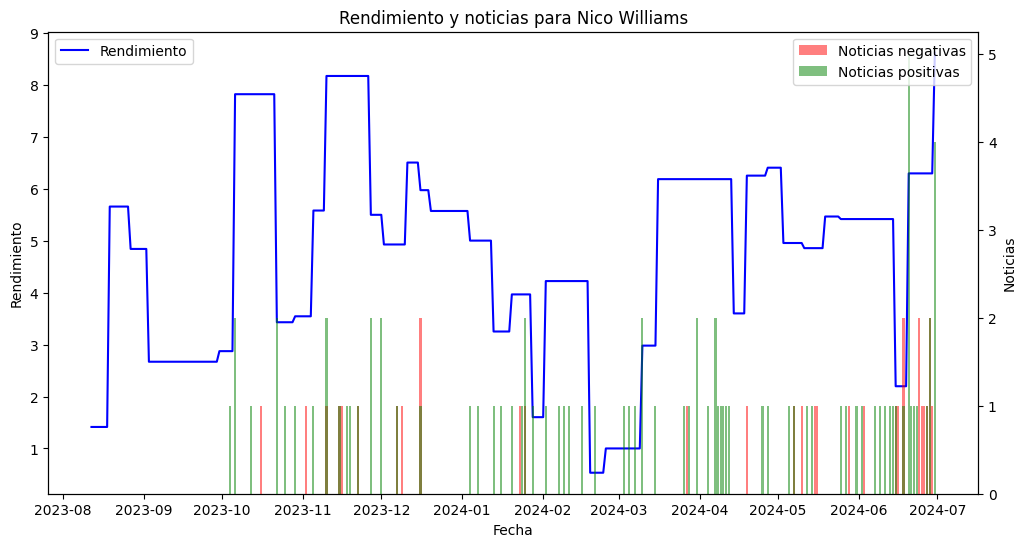

In [55]:
# plotear rendimiento de un jugador y noticias negativas y positivas
def plotear_rendimiento_y_sentimientos(jugador):
    df_jugador = df_completo_con_noticias[df_completo_con_noticias['Player'] == jugador]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_jugador['Fecha'], df_jugador['last_performance'], label='Rendimiento', color='blue')
    ax.set_ylabel('Rendimiento')
    ax.set_xlabel('Fecha')
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.bar(df_jugador['Fecha'], df_jugador['Noticias_negativas'], color='red', alpha=0.5, label='Noticias negativas')
    ax2.bar(df_jugador['Fecha'], df_jugador['Noticias_positivas'], color='green', alpha=0.5, label='Noticias positivas')
    ax2.set_ylabel('Noticias')
    ax2.legend(loc='upper right')
    
    plt.title(f'Rendimiento y noticias para {jugador}')
    plt.show()


plotear_rendimiento_y_sentimientos('Nico Williams')

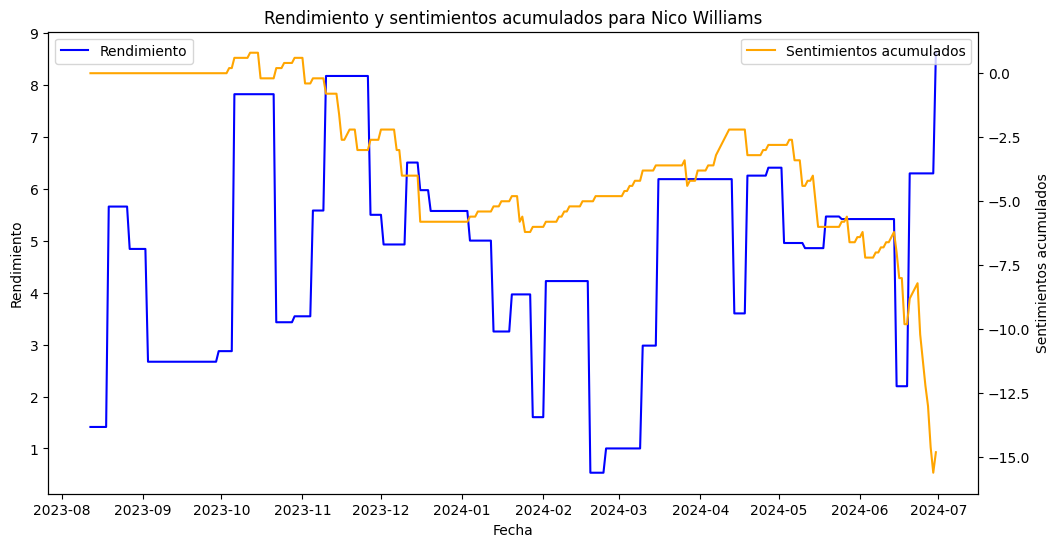

In [56]:
# plotear rendimiento de un jugador y el sentimiento acumulado
def plotear_rendimiento_y_sentimientos_acumulados(jugador):
    df_jugador = df_completo_con_noticias[df_completo_con_noticias['Player'] == jugador]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_jugador['Fecha'], df_jugador['last_performance'], label='Rendimiento', color='blue')
    ax.set_ylabel('Rendimiento')
    ax.set_xlabel('Fecha')
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.plot(df_jugador['Fecha'], df_jugador['Sentimientos_acumulado'], label='Sentimientos acumulados', color='orange')
    ax2.set_ylabel('Sentimientos acumulados')
    ax2.legend(loc='upper right')
    
    plt.title(f'Rendimiento y sentimientos acumulados para {jugador}')
    plt.show()


plotear_rendimiento_y_sentimientos_acumulados('Nico Williams')

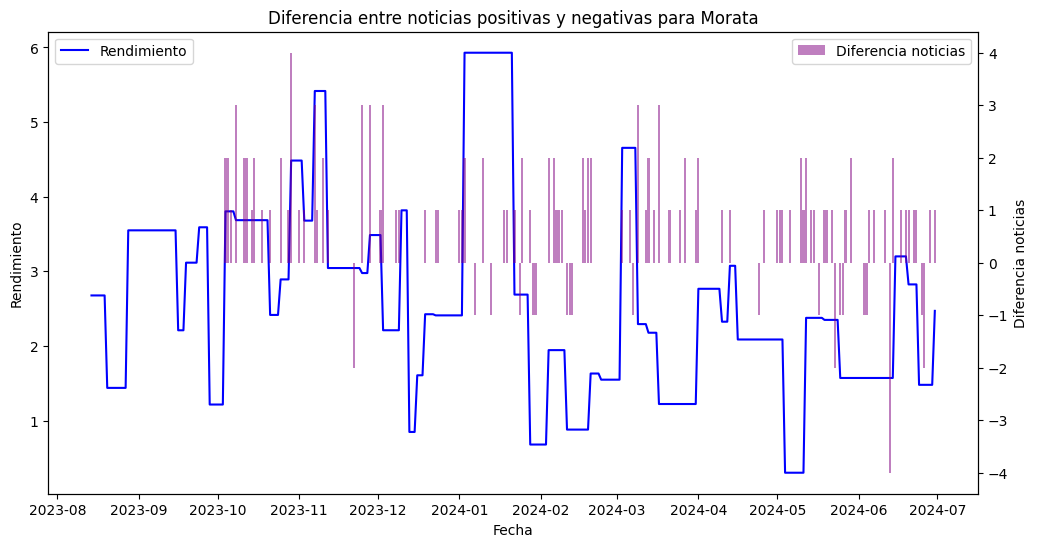

In [59]:
# plotear cada dia la diferencia entre noticias positivas y negativas y el rendimiento
def plotear_diferencia_noticias(jugador):
    df_jugador = df_completo_con_noticias[df_completo_con_noticias['Player'] == jugador]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_jugador['Fecha'], df_jugador['last_performance'], label='Rendimiento', color='blue')
    ax.set_ylabel('Rendimiento')
    ax.set_xlabel('Fecha')
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.bar(df_jugador['Fecha'], df_jugador['Noticias_positivas'] - df_jugador['Noticias_negativas'], color='purple', alpha=0.5, label='Diferencia noticias')
    ax2.set_ylabel('Diferencia noticias')
    ax2.legend(loc='upper right')
    
    plt.title(f'Diferencia entre noticias positivas y negativas para {jugador}')
    plt.show()


plotear_diferencia_noticias('Morata')

In [60]:
# guardar el dataframe en un csv como data_processed_final.csv en la carpeta processed
df_completo_con_noticias.to_csv('processed/data_processed_final.csv', index=False)